# Usage of the Galaxy Builder analysis package

This notebook runs through some example uses of the `gzbuilder_analysis` package (available on Github). 

In this notebook we:
- take an example galaxy and extracts an aggregate model, including logarithmic spiral arms
- render volunteer models to identify the best individual classification
- further optimize this classification
- compare this fitted model it to an optimized version of the aggregate model.

In [1]:
%load_ext autoreload
%autoreload 2

Needed imports (in a verbose manner)

In [2]:
import json
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon
from descartes import PolygonPatch
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from IPython.display import display, update_display, display_html, HTML

import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.spirals as spirals
from gzbuilder_analysis.spirals.oo import Pipeline
import gzbuilder_analysis.aggregation as aggregation
from gzbuilder_analysis.aggregation import average_shape_helpers as ash
import gzbuilder_analysis.rendering as rendering
import gzbuilder_analysis.fitting as fitting

import lib.galaxy_utilities as gu

Define the subject ID to work on 

In [3]:
subject_id = 20902040

Grab the classifications for this galaxy, along with other needed metadate (originally obtained from either the NASA-Sloan Atlas, or SDSS skyserver, but can mostly be found inside the subject metadata)

In [4]:
cls = gu.classifications.query('subject_ids == {}'.format(subject_id))
drawn_arms = spirals.get_drawn_arms(cls)

gal, angle = gu.get_galaxy_and_angle(subject_id)
ba = gal['PETRO_BA90']
im = gu.get_image(subject_id)
psf = gu.get_psf(subject_id)
diff_data = gu.get_diff_data(subject_id)
pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
galaxy_data = np.array(diff_data['imageData'])[::-1]
size_diff = diff_data['width'] / diff_data['imageWidth']

# functions for plotting
tv = lambda v: parsing.transform_val(v, np.array(im).shape[0], gal['PETRO_THETA'])
ts = lambda v: parsing.transform_shape(v, galaxy_data.shape[0], gal['PETRO_THETA'])
ts_a = lambda v: parsing.transform_shape(v, galaxy_data.shape[0], gal['PETRO_THETA'])
imshow_kwargs = dict(cmap='gray', origin='lower', extent=[tv(0), tv(np.array(im).shape[0])]*2)

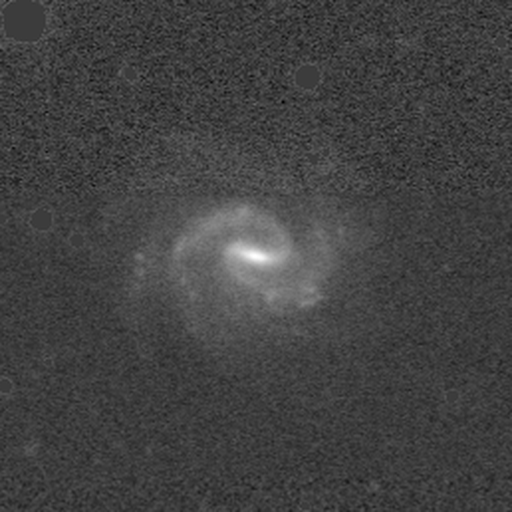

In [5]:
display(HTML('<h3>Image being classified</h3>'))
display(im)

We'll quickly grab the annotations from these classifications, and use `gzbuilder_analysis.parsing` to scale them to Sloan pixels and put them in a more manageable format:

In [6]:
annotations = cls['annotations'].apply(json.loads)
models = annotations.apply(parsing.parse_annotation, size_diff=size_diff)

## Model calculation through clustering

We can make use of unsupervised clustering to group drawn shapes and create a "model by consensus". First we'll visualize the drawn shapes to see what we're working with:

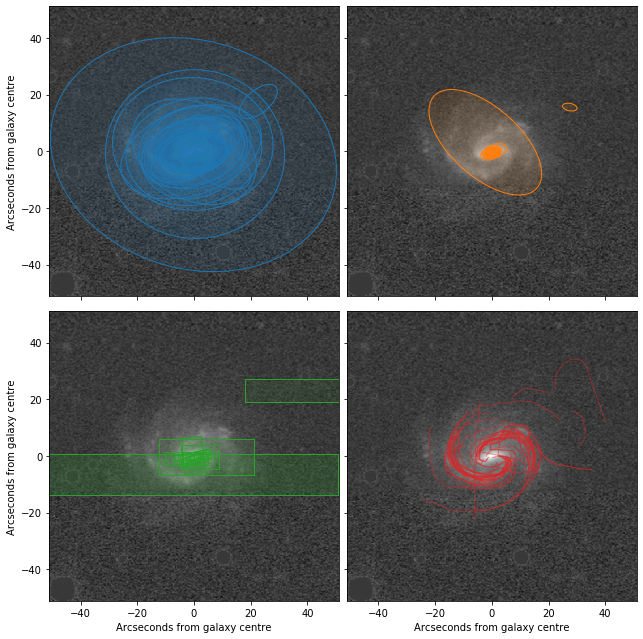

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(9, 9))
axs = [j for i in axs for j in i]
for ax in axs:
    ax.imshow(im, **imshow_kwargs)
for _, model in models.iteritems():
    disk = ash.make_ellipse(model['disk'])
    bulge = ash.make_ellipse(model['bulge'])
    bar = ash.make_box(model['bar'])
    for i, geom in enumerate((disk, bulge, bar)):
        if geom is not None:
            p = PolygonPatch(ts(geom), fc='none', ec='C{}'.format(i), zorder=2, 
                             lw=1)
            p2 = PolygonPatch(ts(geom), fc='C{}'.format(i), ec='none', alpha=0.1, 
                              zorder=2, lw=2)
            axs[i].add_patch(p)
            axs[i].add_patch(p2)
    plt.sca(axs[-1])
for i, arm in enumerate(drawn_arms):
    plt.plot(*tv(arm.T), c='C3', alpha=0.5, linewidth=1)
for ax in axs:
    plt.sca(ax)
    plt.xlim(np.min(imshow_kwargs['extent']), np.max(imshow_kwargs['extent']))
    plt.ylim(np.min(imshow_kwargs['extent']), np.max(imshow_kwargs['extent']))
axs[0].set_ylabel('Arcseconds from galaxy centre')
axs[2].set_ylabel('Arcseconds from galaxy centre')
axs[2].set_xlabel('Arcseconds from galaxy centre')
axs[3].set_xlabel('Arcseconds from galaxy centre')
plt.tight_layout();

It's really easy to extract logarithmic spirals (if that's all you want)

In [8]:
p = spirals.oo.Pipeline(drawn_arms, phi=angle, ba=ba)
arms = p.get_arms()

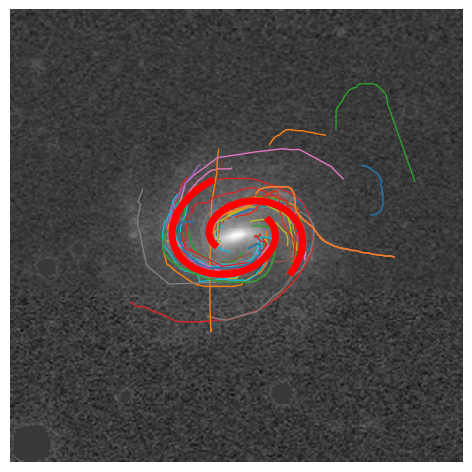

In [9]:
plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(im, origin='lower', cmap='gray')
for arm in p.drawn_arms:
  plt.plot(*arm.T, linewidth=1)
for arm in arms:
  plt.plot(*arm.reprojected_log_spiral.T, 'r', linewidth=5)
plt.axis('off');

Alternatively, you can grab a complete aggregate model very easily (including spiral arms)

In [10]:
agg_res, errors, masks, arms = aggregation.make_model(
    cls,
    gal,
    angle
)
agg_model = parsing.scale_aggregate_model(agg_res, size_diff)

In [11]:
annotations = cls['annotations'].apply(json.loads)
models = annotations.apply(parsing.parse_annotation, size_diff=size_diff)

What components were identified as part of the cluster?

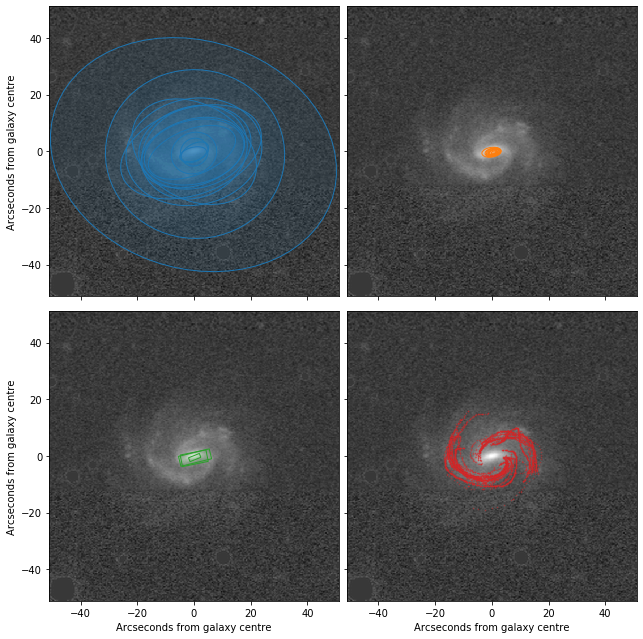

In [12]:
masked_comps = [
    models.apply(lambda m: m[k])[masks[i]]
    for i, k in enumerate(('disk', 'bulge', 'bar'))
]

fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(9, 9))
axs = [j for i in axs for j in i]
for ax in axs:
    ax.imshow(im, **imshow_kwargs)
for i, comps in enumerate(masked_comps):
    for comp in comps:
        shape = (ash.make_ellipse if i < 2 else ash.make_box)(comp)
        p = PolygonPatch(ts(shape), fc='none', ec='C{}'.format(i), zorder=2, 
                         lw=1)
        p2 = PolygonPatch(ts(shape), fc='C{}'.format(i), ec='none', alpha=0.1, 
                          zorder=2, lw=2)
        axs[i].add_patch(p)
        axs[i].add_patch(p2)
for i, arm in enumerate(arms):
    axs[3].plot(*tv(arm.coords).T, '.', c='C3', alpha=0.5, markersize=1)
for ax in axs:
    plt.sca(ax)
    plt.xlim(np.min(imshow_kwargs['extent']), np.max(imshow_kwargs['extent']))
    plt.ylim(np.min(imshow_kwargs['extent']), np.max(imshow_kwargs['extent']))
axs[0].set_ylabel('Arcseconds from galaxy centre')
axs[2].set_ylabel('Arcseconds from galaxy centre')
axs[2].set_xlabel('Arcseconds from galaxy centre')
axs[3].set_xlabel('Arcseconds from galaxy centre')
plt.tight_layout();

And what does the resulting aggregate model look like?

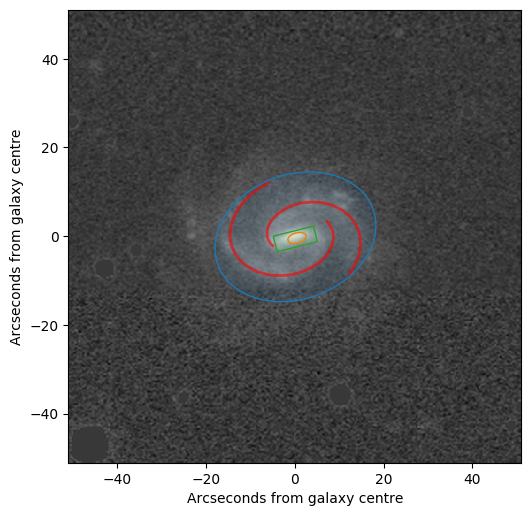

In [13]:
disk = ash.make_ellipse(agg_model['disk'])
bulge = ash.make_ellipse(agg_model['bulge'])
bar = ash.make_box(agg_model['bar'])

plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(im, **imshow_kwargs)
for i, geom in enumerate((disk, bulge, bar)):
        if geom is not None:
            p = PolygonPatch(ts(geom), fc='none', ec='C{}'.format(i),
                             zorder=2, lw=1)
            p2 = PolygonPatch(ts(geom), fc='C{}'.format(i), ec='none',
                              alpha=0.1, zorder=2, lw=2)
            plt.gca().add_patch(p)
            plt.gca().add_patch(p2)
for i, arm in enumerate(arms):
    plt.plot(*tv(arm.reprojected_log_spiral).T, c='r', 
             linewidth=2, alpha=0.6)
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre');

## Best individual classification

If you're not an aggregation kinda person, we could also identify the best individual classification:

In [14]:
annotations = cls['annotations'].apply(json.loads)
models = annotations.apply(parsing.parse_annotation, size_diff=size_diff)

tqdm.pandas(desc='Rendering models')
rendered = models.progress_apply(rendering.calculate_model, image_size=galaxy_data.shape[0], psf=psf)

Rendering models: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


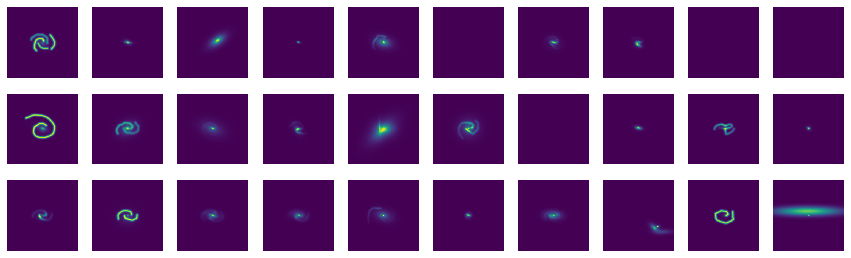

In [15]:
fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(10*1.5, 3*1.5))
for i, ax in enumerate(j for i in axs for j in i):
  plt.sca(ax)
  plt.imshow(rendered.iloc[i]);
  plt.axis('off')

Then calculate the difference between models and data and perform masking (unfortunately not trivial due to weird scalings present in the original code)

In [16]:
tqdm.pandas(desc='Calculating differences')
diffs = rendered.progress_apply(rendering.compare_to_galaxy, args=(galaxy_data,),
                                pixel_mask=pixel_mask, stretch=False)

Calculating differences: 100%|██████████| 32/32 [00:00<00:00, 882.80it/s]


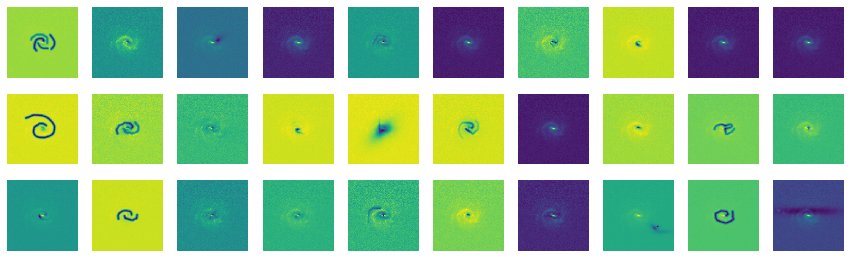

In [17]:
fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(10*1.5, 3*1.5))
for i, ax in enumerate(j for i in axs for j in i):
  plt.sca(ax)
  plt.imshow(diffs.iloc[i]);
  plt.axis('off')

Finally calculate the mean squared error for each model:

In [18]:
def loss(rendered_model):
  return fitting.loss(rendered_model, galaxy_data, pixel_mask)

losses = rendered.apply(loss)
best = losses.idxmin()

In [19]:
print('Best model provided by', cls.loc[best].user_name)
md = fitting.Model(models.loc[best], galaxy_data, psf, pixel_mask)
md

Best model provided by Kamphuisjes


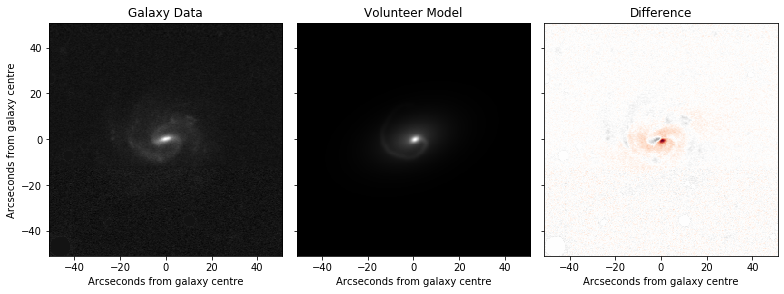

In [20]:
fig, ax = plt.subplots(figsize=(11, 5), ncols=3, sharey=True)
plt.sca(ax[0])
plt.title('Galaxy Data')
ax[0].imshow(galaxy_data, **imshow_kwargs)
plt.ylabel('Arcseconds from galaxy centre')
plt.xlabel('Arcseconds from galaxy centre')
plt.sca(ax[1])
plt.title('Volunteer Model')
ax[1].imshow(rendered[best], **imshow_kwargs)
plt.xlabel('Arcseconds from galaxy centre')
plt.sca(ax[2])
plt.title('Difference')
l = np.abs(diffs[best]).max()
ax[2].imshow(diffs[best], **{**imshow_kwargs, **dict(cmap='RdGy', vmin=-l, vmax=l)})
plt.xlabel('Arcseconds from galaxy centre')
plt.tight_layout();

## Optimization

We can now optimize the model parameters using `gzbulder_analysis.fitting`. Expect a two armed bulge + disc + bar galaxy to take upwards of three minutes to fit (ProFit we love you but you need spirals).

In [21]:
from gzbuilder_analysis.fitting.jupyter import live_fit

For neatness, `gzbuilder_analysis.fitting.jupyter.live_fit` will live-update and track fit iterations per second:

In [22]:
fitted_model, res = live_fit(md)

In [23]:
fitted_rendered = rendering.calculate_model(fitted_model, image_size=galaxy_data.shape[0], psf=psf)
fitted_difference = rendering.compare_to_galaxy(fitted_rendered, galaxy_data, pixel_mask=pixel_mask, stretch=False)

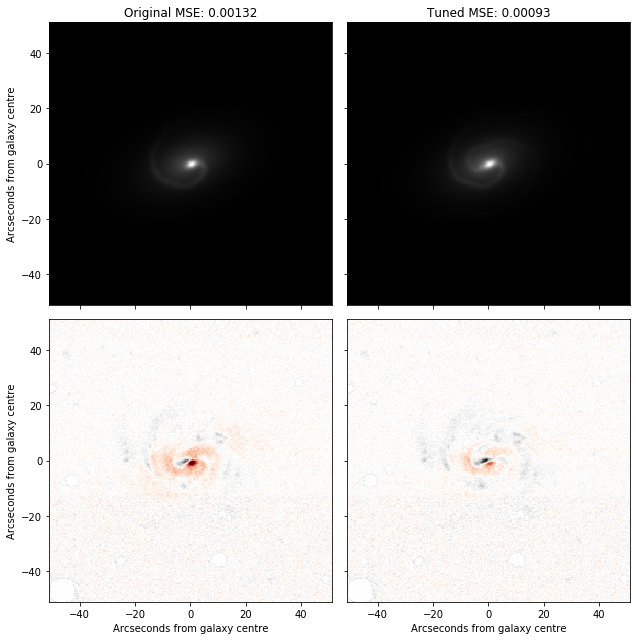

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9, 9), sharex=True, sharey=True)
plt.sca(ax[0][0])
plt.imshow(rendered.loc[best], **imshow_kwargs)
plt.title('Original MSE: {:.5f}'.format(loss(diffs.loc[best])))
plt.ylabel('Arcseconds from galaxy centre')
plt.sca(ax[0][1])
plt.imshow(fitted_rendered, **imshow_kwargs)
plt.title('Tuned MSE: {:.5f}'.format(loss(fitted_difference)))
plt.sca(ax[1][0])
l = np.abs(fitted_difference).max()
plt.imshow(diffs.loc[best], **{**imshow_kwargs, **dict(cmap='RdGy', vmin=-l, vmax=l)})
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')
plt.sca(ax[1][1])
plt.imshow(fitted_difference, **{**imshow_kwargs, **dict(cmap='RdGy', vmin=-l, vmax=l)})
plt.xlabel('Arcseconds from galaxy centre')
plt.tight_layout();

And what if we optimize the aggregate model? As we've had to guess at some of the values, we'll fit the model without spirals, then fit the model as a whole with the spirals starting at low brightness.

In [25]:
agg_model_nosp = deepcopy(agg_model)
spirals_removed = agg_model_nosp.pop('spiral')
agg_model_nosp['spiral'] = np.array([])
agg_model_nosp = fitting.Model(agg_model_nosp, galaxy_data, psf=psf, pixel_mask=pixel_mask)

We will only fit for slider values at first:

In [26]:
agg_model_nosp_sliders_template = [
  ('disk', 'i0'),
  ('bulge', 'i0'),
  ('bulge', 'n'),
  ('bar', 'i0'),
  ('bar', 'n'),
  ('bar', 'c'),
]
fitted_agg_nosp_model, agg_nosp_res = live_fit(agg_model_nosp, template=agg_model_nosp_sliders_template)

And now with low-brightness spirals:

In [27]:
def reset_spiral_intensity(s):
    points, params = s
    new_params = deepcopy(params)
    new_params['i0'] = 0.001
    return [points, new_params]

agg_model_with_spiral = {
  **deepcopy(fitted_agg_nosp_model),
  'spiral': [reset_spiral_intensity(s) for s in spirals_removed],
}
agg_mf = fitting.Model(
    agg_model_with_spiral, galaxy_data,
    psf=psf, pixel_mask=pixel_mask
)

In [28]:
fitted_agg_model, agg_res = live_fit(agg_mf)

We'll visualise the two models for easy comparison:

In [29]:
fitted_agg_rendered = rendering.calculate_model(fitted_agg_model, image_size=galaxy_data.shape[0], psf=psf)
fitted_agg_difference = rendering.compare_to_galaxy(fitted_agg_rendered, galaxy_data, pixel_mask=pixel_mask, stretch=False)

## Comparison between tuned aggregate and tuned best individual

The sum of squared residuals from the tuned best individual model is lower than that of the tuned aggregate - meaning it has converged to a better minimum.

This is a reccuring theme in the galaxy builder results, but no single volunteer can consistently find a better minimum than the aggregate!

In [81]:
(fitted_difference**2).sum(), (fitted_agg_difference**2).sum()

(12.827683323912144, 15.789430970228548)

In [78]:
help(rendering.compare_to_galaxy)

Help on function compare_to_galaxy in module gzbuilder_analysis.rendering:

compare_to_galaxy(arr, galaxy, psf=None, pixel_mask=None, stretch=True)
    Given a calculated model, compare it to the galaxy data. Return a
    (optionally asinh-stretched) difference image.
    A 0.8 multiplier was present in the original rendering code



In [77]:
m = diff_data['multiplier'] / 0.8 # 0.8 due to gzb scaling
print('Scaling images by {:.4f} to convert back to arcseconds'.format(m))

Scaling images by 1.4245 to convert back to arcseconds


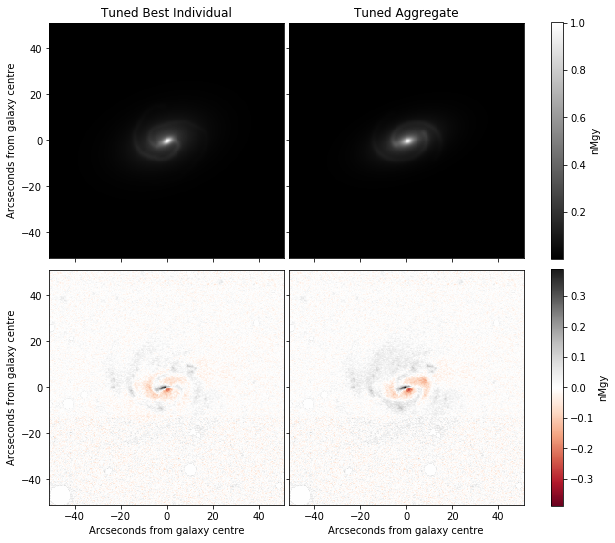

In [97]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 9), sharex=True, sharey=True)
l = (
  min(fitted_rendered.min(), fitted_agg_rendered.min()) * m,
  max(fitted_rendered.max(), fitted_agg_rendered.max()) * m,
)
plt.sca(ax[0][0])
plt.imshow(fitted_rendered * m, **imshow_kwargs)
plt.title('Tuned Best Individual')# MSE: {:.5f}'.format(loss(fitted_rendered)))
plt.ylabel('Arcseconds from galaxy centre')
plt.sca(ax[0][1])
im = plt.imshow(fitted_agg_rendered * m, **imshow_kwargs)
plt.title('Tuned Aggregate')#: {:.5f}'.format(loss(fitted_agg_rendered)))
plt.sca(ax[1][0])
l = max(
  np.abs(fitted_difference).max(),
  np.abs(fitted_agg_difference).max()
) * m
plt.imshow(fitted_difference * m, **{**imshow_kwargs, **dict(cmap='RdGy', vmin=-l, vmax=l)})
plt.xlabel('Arcseconds from galaxy centre')
plt.ylabel('Arcseconds from galaxy centre')
plt.sca(ax[1][1])
im2 = plt.imshow(fitted_agg_difference * m, **{**imshow_kwargs, **dict(cmap='RdGy', vmin=-l, vmax=l)})
plt.xlabel('Arcseconds from galaxy centre')

plt.subplots_adjust(hspace=0.02, wspace=0.02)
c = plt.colorbar(im, ax=ax[0], fraction=0.1, shrink=0.98)
c2 = plt.colorbar(im2, ax=ax[1], fraction=0.1, shrink=0.98)

c.set_label('nMgy')
c2.set_label('nMgy')
plt.savefig('method-paper-plots/bi_vs_agg_comparison.pdf', bbox_inches='tight')

Whether the aggregate model outperforms the best individual classification depends on which minima the fit gets stuck in - generally the best individual has found the best minima. However, as explored elsewhere, no one volunteer seems to consistently find the best minima, so the safest bet is to use the aggregate (and perhaps some form of annealing optimization algorithm which will make small local jumps to get out of potholes).